In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [109]:
import seaborn as sns

### Loading  & cleaning results data

In [200]:
wmt19_results_old = pd.read_csv('evaluate/all_wmt19_results_091620.csv')
wmt19_results_old.method = wmt19_results_old.method.replace('baseline', 'sentencepiece')

In [111]:
wmt19_results = pd.read_csv('./evaluate/all_wmt19_results_112420.csv')
wmt19_results.method = wmt19_results.method.str.replace('baseline', 'sentencepiece')

In [112]:
segmentation_methods = set(wmt19_results.method.unique())

In [113]:
segmentation_methods

{'lmvr-tuned', 'morsel', 'sentencepiece', 'subword-nmt'}

In [114]:
flores_full = pd.read_csv('./evaluate/all_results_091320.csv')
flores_full.method = flores_full.method.str.replace('baseline-fp16', 'sentencepiece')

In [115]:
flores_results = flores_full[flores_full.method.isin(segmentation_methods)].copy()

In [209]:
combined_results = pd.concat([flores_results, wmt19_results], ignore_index=True).copy()
combined_results_old = pd.concat([flores_results, wmt19_results_old], ignore_index=True).copy()

In [210]:
combined_results['chrf3'] = 100*combined_results.chrf3
combined_results_old['chrf3'] = 100*combined_results_old.chrf3

### Comparison against `subword-nmt`

In [124]:
# def compare_to_baseline(results, baseline_method='sentencepiece'):
#     """
#     Creates a dictionary of seed-by-seed comparisons
#     to a baseline for each language pair and model
#     """
#     language_pairs = set(results.pair.unique())
#     segmentation_methods = set(results.method.unique())
#     output = pd.DataFrame()
#     for lang_pair in language_pairs:
#         lang_pair_rows = results[results.pair == lang_pair].copy()
#         baseline = lang_pair_rows[lang_pair_rows.method == baseline_method].set_index('seed')
#         for method in segmentation_methods:
#             if method == baseline_method:
#                 continue
#             method_rows = lang_pair_rows[lang_pair_rows.method == method].set_index('seed')
#             diff = method_rows[['bleu', 'chrf3']] - baseline[['bleu', 'chrf3']]
#             diff['segm_method'] = method
#             diff['lang_pair'] = lang_pair
#             output = pd.concat([output, diff])

#     return output

In [125]:
# baseline_comparisons = compare_to_baseline(combined_results, 
#                                            baseline_method='subword-nmt')

In [126]:
# baseline_comparisons.groupby('segm_method').bleu.describe()

In [127]:
# baseline_comparisons.groupby('segm_method').chrf3.describe()

In [128]:
# baseline_comparisons.groupby(['lang_pair','segm_method']).chrf3.describe()

### Regression models for BLEU and CHRF3 

We can fit the following simple linear model that treats the performance metric, i.e. BLEU or CHRF3, as being a noisy sum of a "language pair" effect, and a "segmentation method" effect.

Our objective is to disentangle the effects of different segmentation methods from the language pair effects.

Mathematically, our model is:

$$
\phi_{lm} = \eta_l + \tau_m + \epsilon_l
$$

where $\phi_{lm} \in \{\text{BLEU, CHRF3}\}$, $l \in \{\text{en-ne, ne-en, en-si, si-en, en-kk, kk-en, en-gu, gu-en}\}$ and $m \in \{\text{sentencepiece, lmvr, morsel, subword-nmt}\}$ and $\epsilon_l$ is a language pair specific variance term.

### BLEU model

For the BLEU model, we exclude Gujarati since the Wikititles corpus produced only 0.0 BLEU scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(4,3)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the BLEU scores, whereas there is no reason to assume that a segmentation method effect exists.

In [41]:
def posterior_predictive_check(obs, posterior_pred, metric_name='bleu', n_bins=30):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism[f'{metric_name}_fake'] = posterior_pred[f'{metric_name}_observed'][rand_ix]
    criticism[f'{metric_name}_observed'] = obs
    criticism.plot(kind='hist', alpha=0.7, title=f'Posterior predictive check: {metric_name}', figsize=(12,6), bins=n_bins)

In [43]:
combined_results_sans_gu = combined_results[~combined_results.pair.str.contains('gu')].copy()

In [87]:
def fit_bleu_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 1}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 1}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    
    bleu_observations = observed_data.bleu
    
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                 mu=b,
                                 sigma=eps,
                                 observed=bleu_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [88]:
(bleu_model_a, 
 prior_bleu_a, 
 posterior_bleu_a, 
 posterior_pred_bleu_a, 
 bleu_lang_pair_encoder, 
 bleu_segm_method_encoder) = fit_bleu_normal_model(combined_results_sans_gu, 
                                           LabelEncoder(), 
                                           LabelEncoder(), 
                                           eta_params={'mu': 4, 'sigma': 3},
                                           tau_params={'mu': 0, 'sigma': 1},
                                           tune=2000, n=2000, target_accept=0.99,
                                           init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 101 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


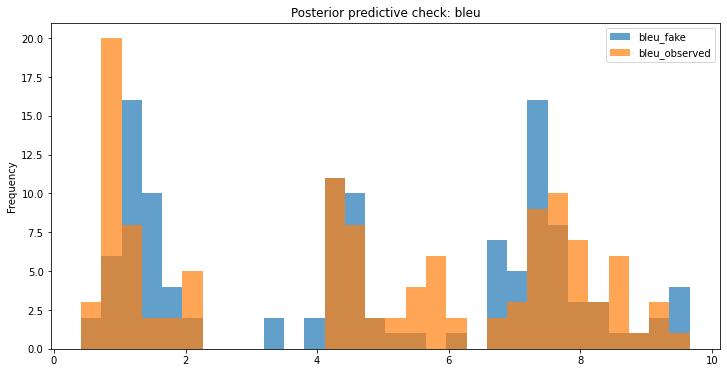

In [89]:
posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_a)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bdba5bc10>,
      dtype=object)

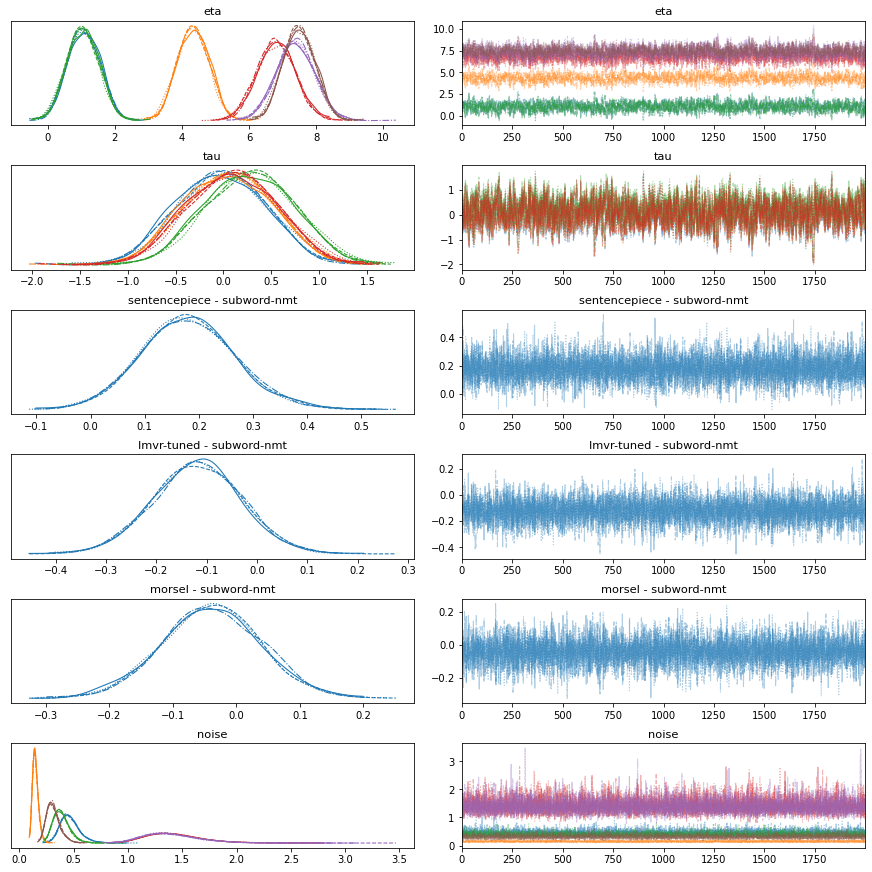

In [47]:
pm.traceplot(posterior_bleu_a)

In [164]:
def posterior_inference_table(segm_method_enc, lang_pair_enc, trace):
    """Computes posterior inference tables for tau and eta"""
    tau = trace['tau']
    tau_means = tau.mean(axis=0)
    tau_stds = tau.std(axis=0)
    segm_methods = segm_method_enc\
                    .inverse_transform([ix for ix, m in enumerate(tau_means)])
    tau_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(tau_means, tau_stds)]
    tau_table = pd.DataFrame({'Segmentation method': segm_methods, 'tau': tau_str})

    eta = trace['eta']
    eta_means = eta.mean(axis=0)
    eta_stds = eta.std(axis=0)
    lang_pairs = lang_pair_enc\
                    .inverse_transform([ix for ix, m in enumerate(eta_means)])
    eta_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(eta_means, eta_stds)]
    eta_table = pd.DataFrame({'Language pair': lang_pairs, 'eta': eta_str})
    return tau_table, eta_table

In [173]:
tau_table_bleu, eta_table_bleu = posterior_inference_table(bleu_segm_method_encoder, bleu_lang_pair_encoder, posterior_bleu_a)

### CHRF3 model

For the chrf3 model, we exclude Gujarati since the Wikititles corpus produced only 0.0 chrf3 scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(15, 7)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the chrf3 scores, whereas there is no reason to assume that a segmentation method effect exists.

In [169]:
def fit_chrf3_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 10}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 10}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    chrf3_observations = observed_data.chrf3
    
    chrf3_model = pm.Model()
    with chrf3_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=chrf3_observations)
        
        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [170]:
(chrf3_model_a, 
 prior_chrf3_a, 
 posterior_chrf3_a, 
 posterior_pred_chrf3_a, 
 chrf3_lang_pair_encoder, 
 chrf3_segm_method_encoder) = fit_chrf3_normal_model(combined_results, 
                                                  LabelEncoder(), 
                                                  LabelEncoder(),
                                                  eta_params={'mu': 15, 'sigma': 7},
                                                  tau_params={'mu': 0, 'sigma': 1},
                                                  tune=2000, n=2000, 
                                                  target_accept=0.9,
                                                  init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


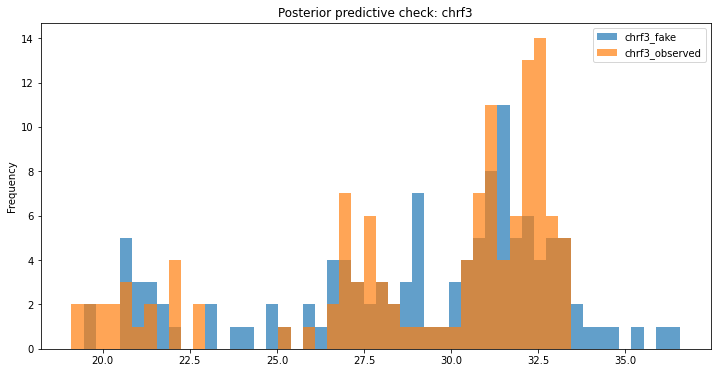

In [171]:
posterior_predictive_check(combined_results.chrf3, posterior_pred_chrf3_a, metric_name="chrf3", n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bd24a0890>,
      dtype=object)

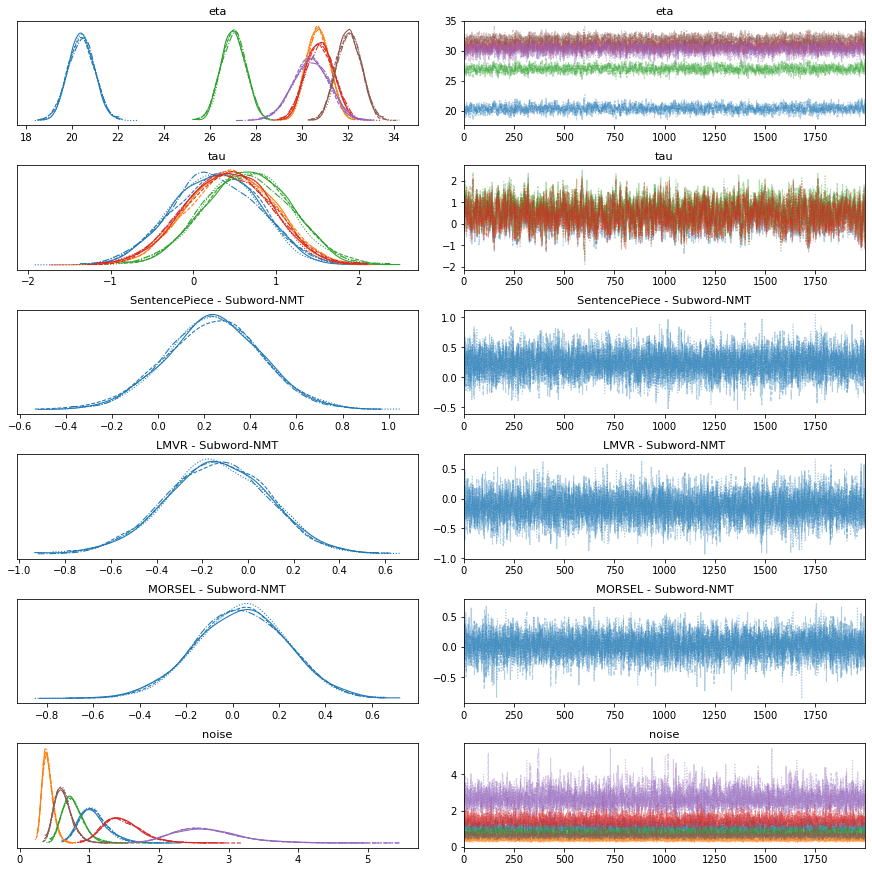

In [172]:
pm.traceplot(posterior_chrf3_a)

In [176]:
tau_table_chrf3, eta_table_chrf3 = posterior_inference_table(chrf3_segm_method_encoder, chrf3_lang_pair_encoder, posterior_chrf3_a)

## With old results

In [211]:
combined_results_sans_gu_old = combined_results_old[~combined_results_old.pair.str.contains('gu')].copy()

In [212]:
combined_results_sans_gu_old

,pair,method,seed,bleu,chrf3
0,en-ne,subword-nmt,10,4.2,31.2
1,ne-en,subword-nmt,10,8.6,32.3
2,en-si,subword-nmt,10,0.8,26.6
3,si-en,subword-nmt,10,7.7,32.7
4,en-ne,subword-nmt,11,4.5,30.9
...,...,...,...,...,...
149,en-kk,morsel,12,0.6,20.5
152,kk-en,morsel,13,1.9,25.1
153,en-kk,morsel,13,0.6,21.4
156,kk-en,morsel,14,1.9,24.2


In [213]:
(bleu_model_old, 
 prior_bleu_old, 
 posterior_bleu_old, 
 posterior_pred_bleu_old,
 bleu_lang_pair_encoder_old, 
 bleu_segm_method_encoder_old) = fit_bleu_normal_model(combined_results_sans_gu_old, 
                                                       LabelEncoder(), 
                                                       LabelEncoder(), 
                                                       eta_params={'mu': 4, 'sigma': 3},
                                                       tau_params={'mu': 0, 'sigma': 1},
                                                       tune=2000, n=2000, target_accept=0.99,
                                                       init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 191 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


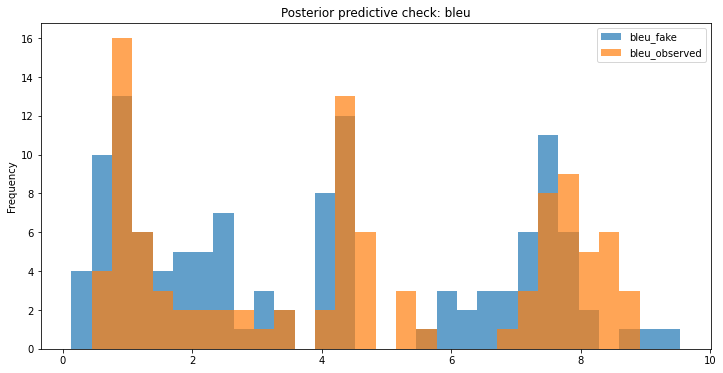

In [214]:
posterior_predictive_check(combined_results_sans_gu_old.bleu, posterior_pred_bleu_old)

In [217]:
(tau_table_bleu_old, 
eta_table_bleu_old) = posterior_inference_table(bleu_segm_method_encoder_old, 
                                                bleu_lang_pair_encoder_old, 
                                                posterior_bleu_old)

In [215]:
(chrf3_model_old, 
 prior_chrf3_old, 
 posterior_chrf3_old, 
 posterior_pred_chrf3_old, 
 chrf3_lang_pair_encoder_old, 
 chrf3_segm_method_encoder_old) = fit_chrf3_normal_model(combined_results_sans_gu_old, 
                                                          LabelEncoder(), 
                                                          LabelEncoder(),
                                                          eta_params={'mu': 15, 'sigma': 7},
                                                          tau_params={'mu': 0, 'sigma': 1},
                                                          tune=2000, n=2000, 
                                                          target_accept=0.9,
                                                          init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


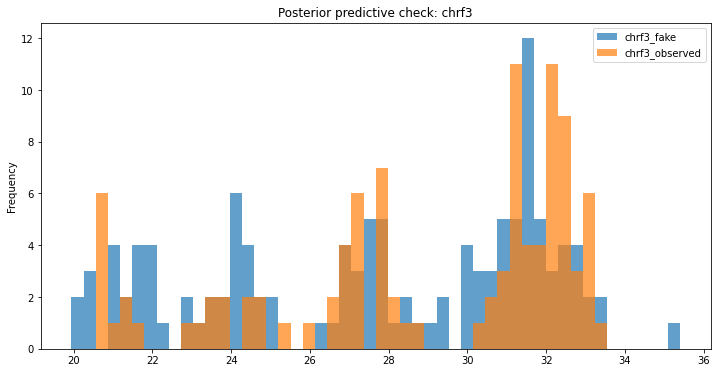

In [216]:
posterior_predictive_check(combined_results_sans_gu_old.chrf3, 
                           posterior_pred_chrf3_old, metric_name="chrf3", n_bins=50)

In [218]:
(tau_table_chrf3_old, 
eta_table_chrf3_old) = posterior_inference_table(chrf3_segm_method_encoder_old, 
                                                chrf3_lang_pair_encoder_old, 
                                                posterior_chrf3_old)

## Comparing posterior inferences - BLEU

In [231]:
tau_table_bleu.join(tau_table_bleu_old, rsuffix=" (old data)")

,Segmentation method,tau,Segmentation method (old data),tau (old data)
0,lmvr-tuned,-0.03 +/- 0.47,lmvr-tuned,-0.20 +/- 0.46
1,morsel,0.05 +/- 0.47,morsel,-0.11 +/- 0.46
2,sentencepiece,0.26 +/- 0.47,sentencepiece,0.24 +/- 0.46
3,subword-nmt,0.09 +/- 0.47,subword-nmt,0.05 +/- 0.46


In [232]:
eta_table_bleu.join(eta_table_bleu_old, rsuffix=" (old data)")

,Language pair,eta,Language pair (old data),eta (old data)
0,en-kk,1.07 +/- 0.48,en-kk,0.68 +/- 0.46
1,en-ne,4.34 +/- 0.47,en-ne,4.43 +/- 0.46
2,en-si,1.04 +/- 0.48,en-si,1.14 +/- 0.47
3,kk-en,6.80 +/- 0.57,kk-en,2.26 +/- 0.48
4,ne-en,7.37 +/- 0.56,ne-en,7.48 +/- 0.54
5,si-en,7.48 +/- 0.48,si-en,7.58 +/- 0.47


## Comparing posterior inferences - CHRF3

In [238]:
tau_table_chrf3.join(tau_table_chrf3_old, rsuffix=" (old KK data)")

,Segmentation method,tau,Segmentation method (old KK data),tau (old KK data)
0,lmvr-tuned,0.27 +/- 0.52,lmvr-tuned,0.35 +/- 0.50
1,morsel,0.44 +/- 0.51,morsel,0.43 +/- 0.50
2,sentencepiece,0.64 +/- 0.51,sentencepiece,0.43 +/- 0.50
3,subword-nmt,0.40 +/- 0.51,subword-nmt,0.32 +/- 0.51


In [239]:
eta_table_chrf3.join(eta_table_chrf3_old, rsuffix=" (old KK data)")

,Language pair,eta,Language pair (old KK data),eta (old KK data)
0,en-kk,20.41 +/- 0.56,en-kk,20.30 +/- 0.51
1,en-ne,30.70 +/- 0.50,en-ne,30.76 +/- 0.50
2,en-si,27.03 +/- 0.52,en-si,27.08 +/- 0.52
3,kk-en,30.78 +/- 0.60,kk-en,23.63 +/- 0.52
4,ne-en,30.38 +/- 0.77,ne-en,30.43 +/- 0.79
5,si-en,32.05 +/- 0.52,si-en,32.10 +/- 0.51


## Plots for paper

In [65]:
for_paper = combined_results.copy()

In [69]:
for_paper.columns = ['Language pair', 'Segmentation method', 'Seed', 'BLEU', 'CHRF3']
for_paper['Language pair'] = for_paper['Language pair'].str.upper()

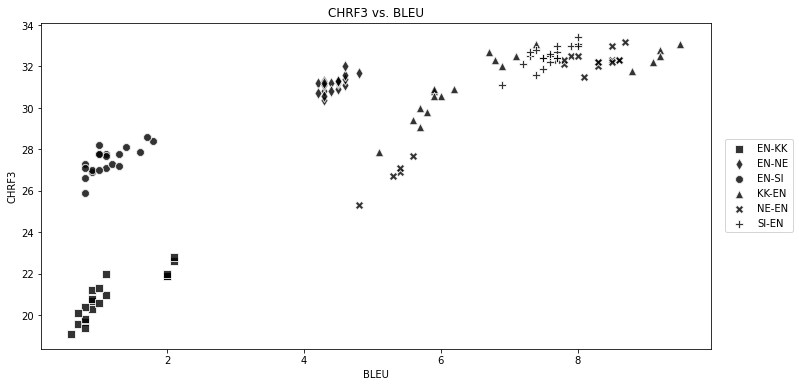

In [237]:
from itertools import cycle
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.patch.set_facecolor('#FFFFFF')
lang_pairs = for_paper.groupby('Language pair')
markers = ['s', 'd', '8', '^', 'X', 'P', 'p', 'o']
legend_labels = []
for (name, lang_pair), marker in zip(lang_pairs, cycle(markers)):
    ax.scatter(lang_pair.BLEU, lang_pair.CHRF3, 
               marker=marker, color='k', alpha=.8, 
               s=70, edgecolor='white')
    legend_labels.append(name)
ax.set_xlabel('BLEU')
ax.set_ylabel('CHRF3')
ax.legend(labels=legend_labels, loc='center right', 
          ncol=1, bbox_to_anchor=(1.13,  .5))
ax.set_title('CHRF3 vs. BLEU')
plt.show()